In [1]:
from __future__ import division
import numpy as np
import itertools as iter
import matplotlib.pyplot as plt
from scipy.integrate import simps
import collections
%matplotlib inline

In [2]:
# setup KL coefficients
a1 = lambda x, m: np.sin(2*np.pi*(m+1)*x)
alpha = 2             # scaling parameter from Schwab
a2 = lambda x, m: 0.95*x**(-alpha*m)
KL_type = 0
a = [a1, a2][KL_type]
ensure_iterable = lambda x: x if isinstance(x, collections.Iterable) else (x,)
KL = lambda x, y : a(x,0) + sum([a(x,m)*yi for m, yi in enumerate(ensure_iterable(y))])

# setup discretisation
Nx, Ny = 100, 50
dx, dy = 1/Nx, 1/Ny
mx = np.linspace(0, 1, Nx)
my = np.linspace(-1, 1, Ny)

# setup truth, noise and priors
true_y = [0.6, -0.3, 0]
#true_y = [-0.6, -0.3]
#true_y = [-0.6]
#mu = [0.1, -0.6, 0.9]
mu = [0.1, -0.6]
#mu = [0.1]
#sigma = [1.5, 0.9, 0.5]
sigma = [1.5, 0.9]
#sigma = [1.5]
M = len(true_y)
Gauss_prior = False
if Gauss_prior:
    pi_y = [lambda x: 1/(np.sqrt(2*np.pi)*sigma_i)*np.exp(-0.5*((x-mu_i)/sigma_i)**2) for mu_i, sigma_i in zip(mu, sigma)]    
else:
    pi_y = [lambda x: 0.5*np.ones_like(x)]*M

# setup measure points
measurePoints = [1,2,4,11,22,33,44,55,66,77,88,99,75,85]
#measurePoints = [k for k in range(int(Nx))]
Nm = len(measurePoints)


In [3]:
# evaluate integrals in y_k
def integrate_ydims(y_measurements, pi_y=pi_y, dy=dy, my=my):
    M, Ny = len(y_measurements.shape), len(my)
    assert len(pi_y) == M
    # iterate y dimensions
    y_int = np.ones((Ny, M))
    for yi, dpi in enumerate(pi_y):
        # make copy then contract iteratively over dimensions
        yi_int = np.array(y_measurements)
        di = 0
        # contraction loop
        for d in range(M):
            if d != yi:
#                print "\t", yi_int.shape
#                print "\t===", yi_int[:,di].shape, dpi(my).shape
                yi_int[:,di] *= dpi(my)
#                print "\tcontract dim", d, "from ", yi_int.shape
                yi_int = simps(yi_int, dx=dy, axis=di)
#                print "...to", yi_int.shape
            else:
                di += 1
        y_int[:,yi] = yi_int
    # evaluate expectation
    Z = simps(y_int[:,0]*pi_y[0](my), dx=dy)
    return y_int, Z

In [4]:
# create measurements    
measurements = np.zeros([Nm] + [Ny]*M)
idx = [i for i in range(Ny)]
for i, p in enumerate(measurePoints):
    for mu_y in iter.product(*[idx]*M):
#        print mx[p], np.array(mu_y)*dy#*hy, KL(mx[p], np.array(mu_y)*hy)
#        measurements[(i,)+tuple(mu_y)] = KL(mx[p], np.array(mu_y)*hy)
        measurements[(i,)+tuple(mu_y)] = (KL(mx[p], true_y) - KL(mx[p], my[list(mu_y)]))**2

# evaluate exponential of inner product
y_measurements = np.sum(measurements, axis=0)
likelihood = np.exp(-0.5*y_measurements)

# evaluate marginal densities
y_int, Z = integrate_ydims(likelihood, pi_y)
print y_int.shape, Z

(50, 3) 0.0494451242466


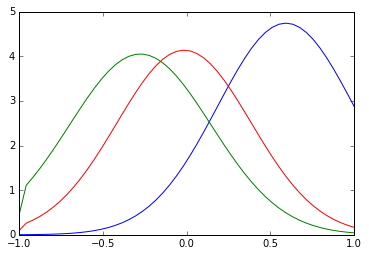

In [5]:
for yi in y_int.T:
    plt.plot(my, yi/Z)
plt.show()